In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
data = pd.read_csv("/content/city_day.csv")
data.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,01-01-2015,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,02-01-2015,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,03-01-2015,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,04-01-2015,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,05-01-2015,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='mixed')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

In [ ]:
date_format1 = "%m/%d/%Y"
data['Date'] = pd.to_datetime(data['Date'], format=date_format1, errors='coerce')
invalid_dates = data['Date'].isnull()
date_format2 = "%m-%d-%Y"
data.loc[invalid_dates, 'Date'] = pd.to_datetime(data.loc[invalid_dates, 'Date'], format=date_format2, errors='coerce')

In [ ]:
data.shape[0]

29531

In [ ]:
data.duplicated().any()


False

In [ ]:
data.isnull().sum()

City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
Year              0
Month             0
Day               0
dtype: int64

<Axes: >

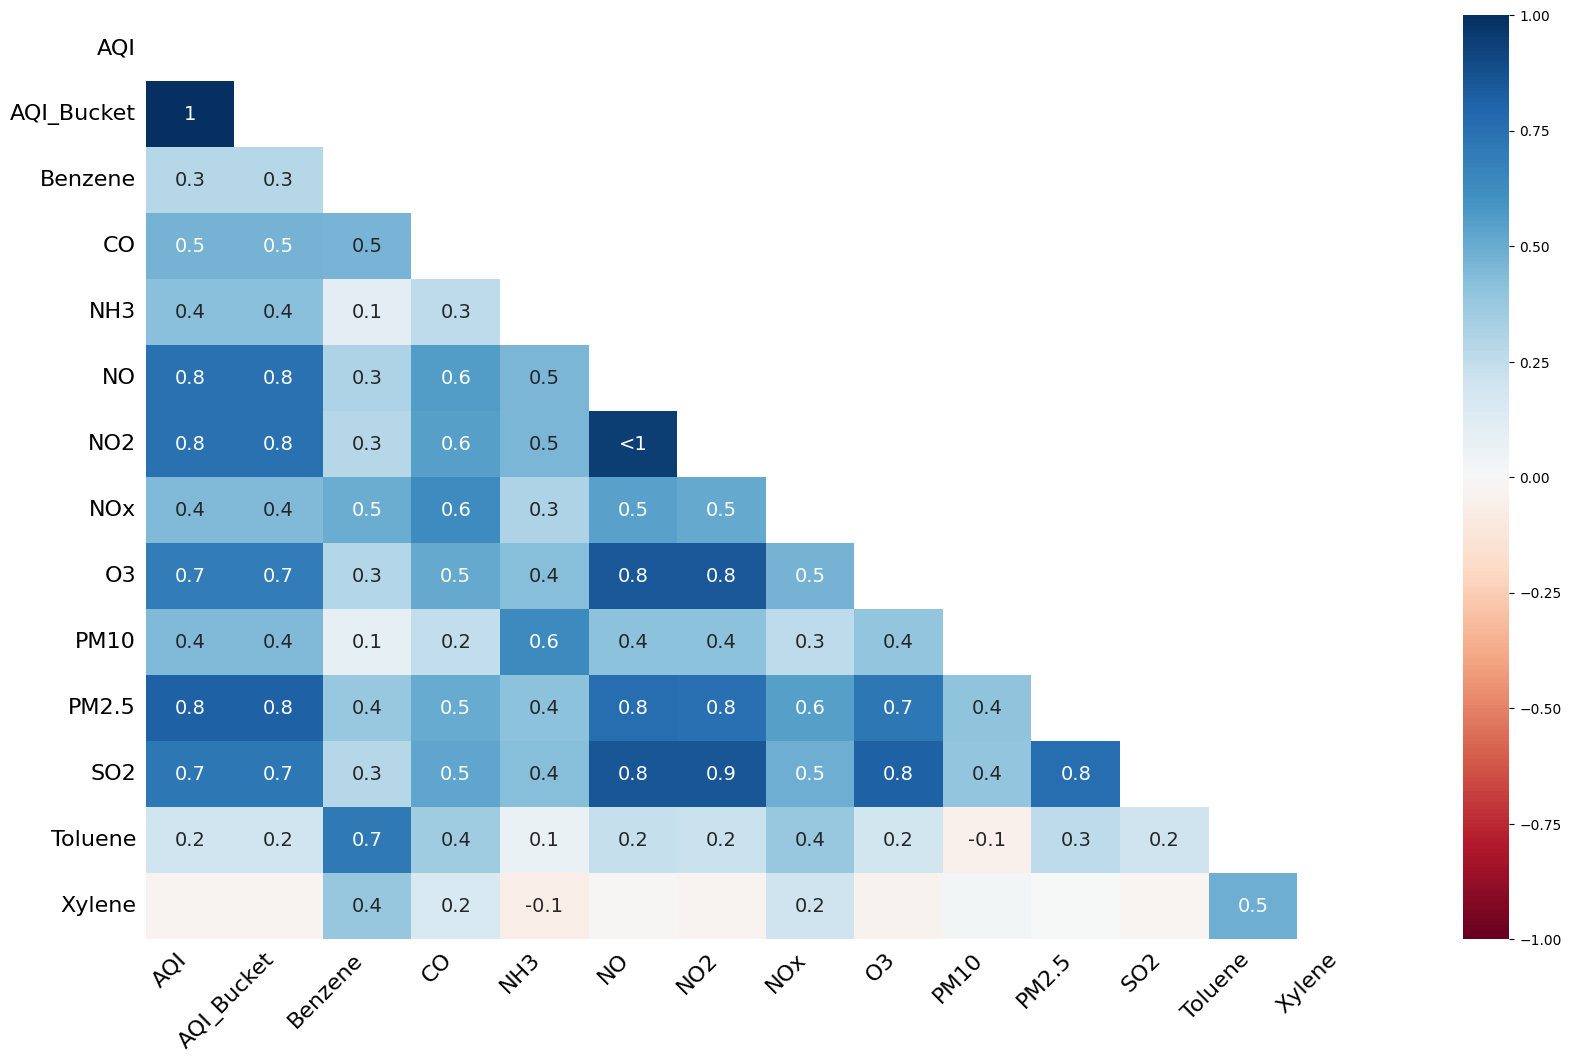

In [ ]:
columns_to_include = data.columns.difference(['Season', 'City', 'Date'])

data_subset = data[columns_to_include]

msno.heatmap(data_subset)

In [ ]:
print(data.columns)

Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'Year',
       'Month', 'Day'],
      dtype='object')


In [ ]:
data_fill = data.copy()
columns_to_impute = ['Date','City','PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
data_fill['Date'] = pd.to_datetime(data_fill['Date'])
data_fill[columns_to_impute] = data_fill[columns_to_impute].fillna(data_fill[columns_to_impute].groupby(["City", pd.Grouper(key="Date", freq="5D")]).transform("mean"))
data_fill = data_fill.fillna(method="bfill")

In [ ]:
data_fill.describe()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Year,Month,Day
count,29531,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000,29531.000000
mean,2018-05-17 01:33:40.344722432,66.784152,120.775665,18.998039,28.461945,35.581270,26.004363,2.570033,22.446069,33.467825,3.427563,8.128898,3.728933,168.480546,2017.887914,6.362771,15.667129
min,2015-01-01 00:00:00,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000,2015.000000,1.000000,1.000000
25%,2017-04-08 00:00:00,27.780000,61.545000,5.960000,11.860000,13.690000,7.895000,0.510000,5.810000,17.240000,0.130000,0.310000,0.180000,79.000000,2017.000000,3.000000,8.000000
50%,2018-08-04 00:00:00,49.280000,92.990000,10.570000,22.245000,24.940000,18.870000,0.910000,9.740000,29.540000,1.300000,2.660000,3.140000,118.000000,2018.000000,6.000000,16.000000
75%,2019-08-28 00:00:00,79.980000,154.005000,23.285000,36.860000,44.870000,36.400000,1.520000,17.780000,44.505000,3.330000,9.740000,4.150000,213.000000,2019.000000,9.000000,23.000000
max,2020-12-06 00:00:00,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000,2020.000000,12.000000,31.000000
std,NaN,63.078443,92.848477,24.125408,24.530843,34.158059,27.234907,7.695754,39.072345,21.445104,14.743734,18.905688,5.093883,141.923045,1.533783,3.444773,8.901108


In [ ]:
data.describe()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Year,Month,Day
count,29531,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000,29531.000000,29531.000000,29531.000000
mean,2018-05-17 01:33:40.344722432,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581,2017.887914,6.362771,15.667129
min,2015-01-01 00:00:00,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000,2015.000000,1.000000,1.000000
25%,2017-04-08 00:00:00,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000,2017.000000,3.000000,8.000000
50%,2018-08-04 00:00:00,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000,2018.000000,6.000000,16.000000
75%,2019-08-28 00:00:00,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000,2019.000000,9.000000,23.000000
max,2020-12-06 00:00:00,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000,2020.000000,12.000000,31.000000
std,NaN,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585,1.533783,3.444773,8.901108


In [ ]:
data_fill.isnull().sum()

City          0
Date          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
Year          0
Month         0
Day           0
dtype: int64

In [ ]:
cities_all = data.pivot_table(values='AQI', index=['Date'], columns='City')
cities_all=cities_all.add_suffix('_AQI')
cities=cities_all.resample(rule='MS').mean()
cities.head()

City,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,...,Jorapokhar_AQI,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,334.181818,NaN,NaN,NaN,106.333333,NaN,NaN,NaN,173.555556,NaN,...,NaN,NaN,NaN,195.222222,NaN,350.000000,NaN,NaN,NaN,NaN
2015-02-01,518.681818,NaN,NaN,NaN,122.555556,NaN,NaN,NaN,169.888889,NaN,...,NaN,NaN,NaN,158.777778,NaN,324.000000,NaN,NaN,NaN,NaN
2015-03-01,426.413793,NaN,NaN,NaN,118.550000,NaN,NaN,NaN,220.285714,NaN,...,NaN,NaN,NaN,221.350000,NaN,258.000000,NaN,NaN,NaN,NaN
2015-04-01,307.708333,NaN,NaN,NaN,107.555556,NaN,NaN,NaN,155.115385,NaN,...,NaN,NaN,NaN,139.846154,NaN,261.666667,NaN,NaN,NaN,NaN
2015-05-01,294.074074,NaN,NaN,NaN,105.321429,NaN,NaN,NaN,186.074074,NaN,...,NaN,NaN,NaN,154.214286,NaN,314.333333,NaN,NaN,NaN,NaN


In [ ]:
cities['India_AQI']=cities.mean(axis=1)
cities.head()

City,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,...,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI,India_AQI
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,334.181818,NaN,NaN,NaN,106.333333,NaN,NaN,NaN,173.555556,NaN,...,NaN,NaN,195.222222,NaN,350.000000,NaN,NaN,NaN,NaN,234.257925
2015-02-01,518.681818,NaN,NaN,NaN,122.555556,NaN,NaN,NaN,169.888889,NaN,...,NaN,NaN,158.777778,NaN,324.000000,NaN,NaN,NaN,NaN,257.032210
2015-03-01,426.413793,NaN,NaN,NaN,118.550000,NaN,NaN,NaN,220.285714,NaN,...,NaN,NaN,221.350000,NaN,258.000000,NaN,NaN,NaN,NaN,236.820923
2015-04-01,307.708333,NaN,NaN,NaN,107.555556,NaN,NaN,NaN,155.115385,NaN,...,NaN,NaN,139.846154,NaN,261.666667,NaN,NaN,NaN,NaN,203.609493
2015-05-01,294.074074,NaN,NaN,NaN,105.321429,NaN,NaN,NaN,186.074074,NaN,...,NaN,NaN,154.214286,NaN,314.333333,NaN,NaN,NaN,NaN,216.341252


<Axes: xlabel='Date'>

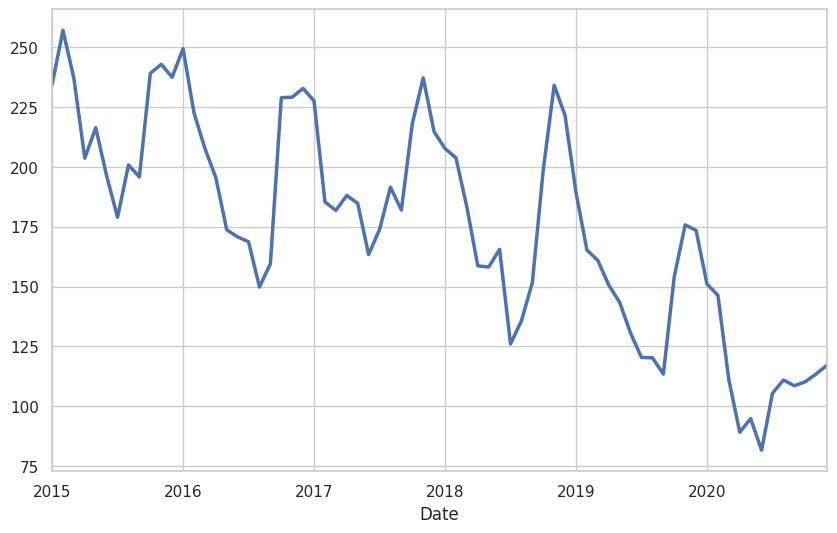

In [ ]:
cities.reset_index()

sns.set_theme(style='whitegrid')

cities['India_AQI'].plot(kind='line',grid=True,figsize=(10, 6), linewidth=2.5)

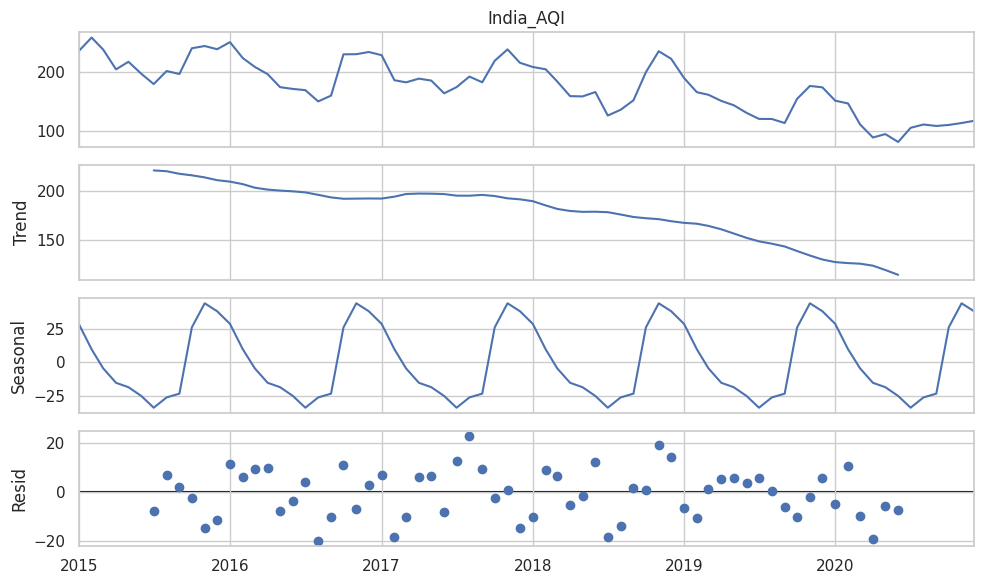

In [ ]:
plt.rcParams['figure.figsize'] = (10, 6);
cities['India_AQI']=cities.mean(axis=1)
fig = seasonal_decompose(cities['India_AQI'], model='additive').plot()

In [ ]:
dftest = adfuller(cities['India_AQI'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  1.712156
p-value                         0.998158
#Lags Used                     11.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64

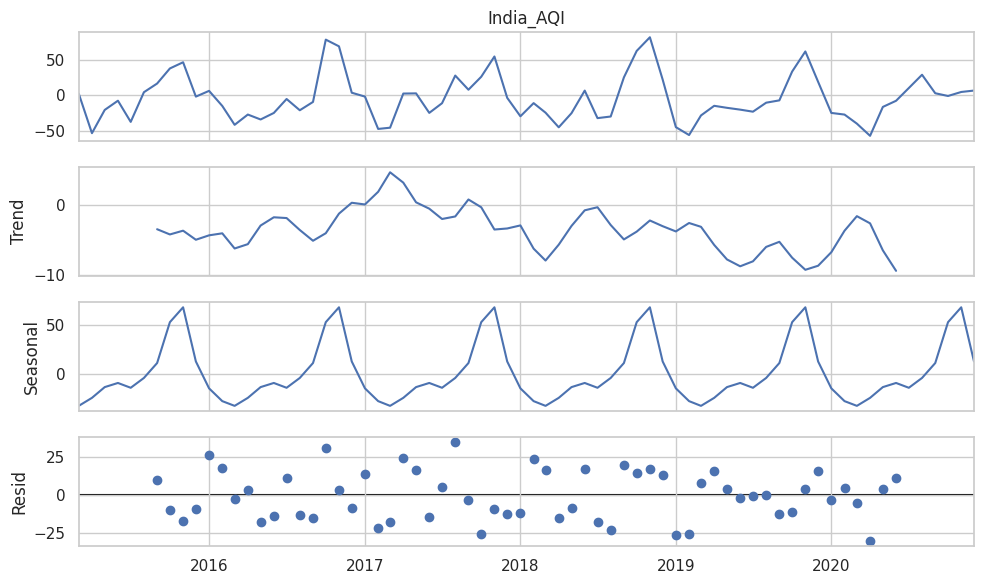

In [ ]:
diff = cities['India_AQI'].diff(periods=2)
diff.dropna(inplace=True)
fig = seasonal_decompose(diff, model='additive').plot()

In [ ]:
dftest = adfuller(diff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -6.400496e+00
p-value                        2.001116e-08
#Lags Used                     9.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00
dtype: float64

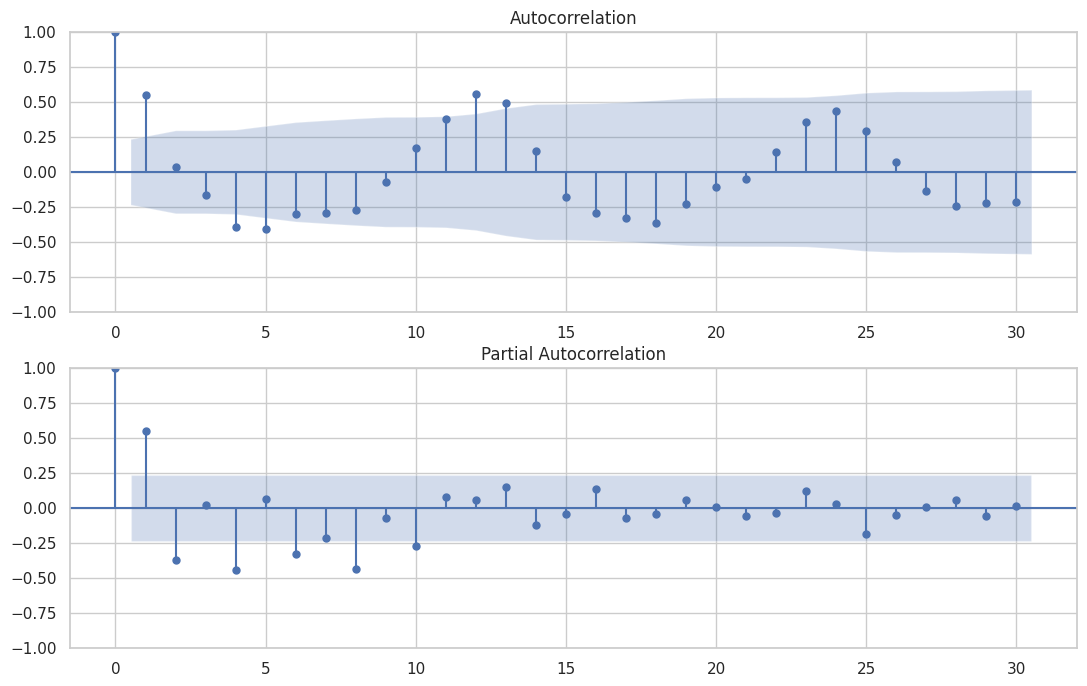

In [ ]:
fig, ax = plt.subplots(2,figsize=(13, 8))
ax[0] = plot_acf(diff, lags=30, ax=ax[0])
ax[1] = plot_pacf(diff,lags=30, ax=ax[1])

In [ ]:
!pip install pmdarima;
from pmdarima import auto_arima;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:00


In [ ]:
auto_arima(y=cities['India_AQI'],start_p=1,start_P=1,start_q=1,start_Q=1,seasonal=True,m=12, stepwise=\
          True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   72
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -299.467
Date:                              Thu, 18 Apr 2024   AIC                            608.933
Time:                                      15:32:44   BIC                            620.247
Sample:                                  01-01-2015   HQIC                           613.432
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0489      0.131     -0.373      0.709      -0.306       0.208
ma.L2         -0.6289      0.092     -6.828      0.000      -0.809      -0.448
ar.S.L12       0.9731      0.056     17.313      0.000       0.863       1.083
ma.S.L12      -0.7481      0.280     -2.675      0.007      -1.296      -0.200
sigma2       219.9629     39.527      5.565      0.000     142.491     297.435
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.49   Prob(JB):                         0.93
Heteroskedasticity (H):               0.83   Skew:                            -0.07
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train_data=cities['India_AQI'][:'2018-12']
test_data=cities['India_AQI'][:'2019-12']

model=SARIMAX(train_data,order=(0,1,2),seasonal_order=(1,0,1,12), trend='n')
results=model.fit()

results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            India_AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -199.753
Date:                              Thu, 18 Apr 2024   AIC                            409.506
Time:                                      15:32:47   BIC                            418.757
Sample:                                  01-01-2015   HQIC                           412.987
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0566      0.095     -0.599      0.549      -0.242       0.129
ma.L2         -0.7884      0.115     -6.878      0.000      -1.013      -0.564
ar.S.L12       0.9993      0.107      9.347      0.000       0.790       1.209
ma.S.L12      -0.9474      3.716     -0.255      0.799      -8.231       6.337
sigma2       168.6808    608.010      0.277      0.781   -1022.997    1360.359
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.67   Prob(JB):                         0.83
Heteroskedasticity (H):               0.90   Skew:                            -0.21
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

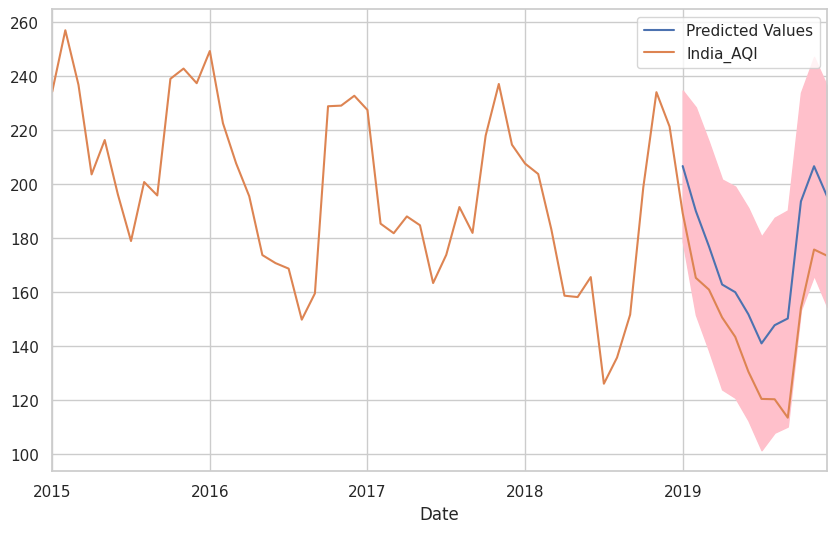

In [ ]:
fig, ax= plt.subplots(figsize=(10,6))
forecasts = results.get_forecast(steps=12, dynamic=True)

confidence_intervals=forecasts.conf_int()
lower_limits = confidence_intervals.loc[:,'lower India_AQI']
upper_limits = confidence_intervals.loc[:,'upper India_AQI']

forecasts.predicted_mean.plot(legend=True, ax=ax, label ='Predicted Values')
plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')

test_data.plot(legend=True, ax=ax)

In [ ]:
from sklearn.metrics import mean_squared_error

test= cities['India_AQI']['2019-01':'2019-12']
RMSE=np.sqrt(mean_squared_error(forecasts.predicted_mean,test))
print('RMSE = ',RMSE)

y_true=test
y_pred= forecasts.predicted_mean
mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE = ', mape)

RMSE =  25.12137871966291
MAPE =  16.523531991406173


<Axes: xlabel='Date'>

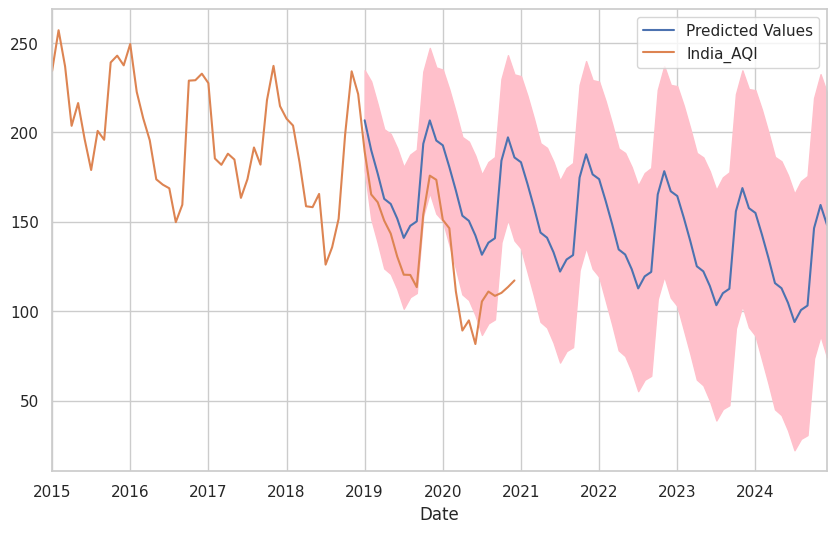

In [ ]:
fig, ax= plt.subplots(figsize=(10,6))

forecasts = results.get_forecast(steps=72, dynamic=True)

confidence_intervals=forecasts.conf_int()
lower_limits = confidence_intervals.loc[:,'lower India_AQI']
upper_limits = confidence_intervals.loc[:,'upper India_AQI']

forecasts.predicted_mean.plot(legend=True, ax=ax, label ='Predicted Values')

plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')
cities['India_AQI'].plot(legend=True, ax=ax)

In [ ]:
predicted_mean_values = forecasts.predicted_mean
print(predicted_mean_values)

2019-01-01    206.699249
2019-02-01    190.029218
2019-03-01    176.923062
2019-04-01    162.803289
2019-05-01    159.947737
                 ...    
2024-08-01    100.665240
2024-09-01    103.152817
2024-10-01    146.382861
2024-11-01    159.371395
2024-12-01    148.158405
Freq: MS, Name: predicted_mean, Length: 72, dtype: float64


In [ ]:
user_date = input("Enter the date (YYYY-MM-DD): ")
user_date = pd.to_datetime(user_date, format='%Y-%m-%d')
aqi_value = predicted_mean_values.loc[user_date]
print(f"Date: {user_date.date()}, Predicted AQI: {aqi_value:.2f}")

Enter the date (YYYY-MM-DD): 2022-10-01
Date: 2022-10-01, Predicted AQI: 165.25
